In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import time
import re
import seaborn as sns
import pickle as pkl
sns.set(style="ticks")

import spacy
from textblob import TextBlob
from gensim.scripts import glove2word2vec
from gensim.models import KeyedVectors

from keras.layers import *
from keras import Model, Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import keras.callbacks as kc
import keras.backend as K

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from helpers import *
from twitter_preprocess import twitter_preprocess
import keras_models as m

Using TensorFlow backend.


In [3]:
wv_en = KeyedVectors.load_word2vec_format("./glove100.w2v")
wv_es = KeyedVectors.load_word2vec_format("./glove_spanish.vec")

In [17]:
clfs = {"en":{},"es":{}}

In [4]:
# CONFIG
lang = "en"
task = "hs"

# Load Vocabs

wv = {"en": wv_en, "es": wv_es}[lang]

with open("en_swearwords.pkl","rb") as f:
    swearwords = pkl.load(f)

with open("en_racism_f.pkl","rb") as f:
    racism_f = pkl.load(f)

with open("en_sexism_f.pkl","rb") as f:
    sexism_f = pkl.load(f)

# Data Import
df = pd.read_csv("data/train_{}.tsv".format(lang), encoding="UTF-8", delimiter="\t")

texts = df.text
y = df.HS.values

if task != "hs":
    texts = df.text[df.HS == 1]
    if task == "ag":
        y = df.AG[df.HS == 1].values
    elif task == "tr":
        y = df.TR[df.HS == 1].values

In [177]:
## Add Addtional Datasets
# df2 = pd.read_csv("data/support_en.csv", encoding="ISO-8859-1")
# df2["y"] = (df2.does_this_tweet_contain_hate_speech == 'The tweet contains hate speech').apply(int)

# texts = concat((texts, df2.tweet_text))
# y = concat((y, df2.y.values))

In [19]:
def reshape(samples):
    return (sample.reshape(sample.shape[0], -1) for sample in samples)

In [10]:
glove_pipe = [
    ("preprocess", apply(twitter_preprocess)),
    ("splitting", apply(custom_split)),
    ("vectorizing", apply(tokens_to_wv, wv=wv)),
    ("padding", apply(pad_sequences, False, maxlen=200, value=wv["<space>"] if lang=="en" else wv["desconocido"], padding="post", dtype='float32'))
    #,("train_test_split", apply(train_val_test_split, False, y=y, val_size=0.1, test_size=.1, limit_testset=len(df)))
    #,("reshape", apply(reshape, False))
]

padded_sequence_pipe = [
    ("preprocess", apply(twitter_preprocess)),
    ("sequence_tokenize", apply(sequence_tokenize, False)),
    ("padding", apply(pad_sequences, False, value=-1, padding="post", dtype='int32')),
    ("train_test_split", apply(train_val_test_split, False, y=y, val_size=.1, test_size=.1, limit_testset=len(df)))
]

ngram_pipe = [
    ("preprocess", apply(twitter_preprocess)),
    ("ngram_tfidf", apply(ngram_tfidf, False, ngram_range=(1,4), max_features=100000, stem=True, stop_words="english" if lang=="en" else None)),
    ("train_test_split", apply(train_val_test_split, False, y=y, val_size=0.1, test_size=.1, limit_testset=len(df)))
]

char_ngram_pipe = [
    ("ngram_tfidf", apply(ngram_tfidf, False, ngram_range=(10,15), max_features=300000, analyzer="char")),
    ("train_test_split", apply(train_val_test_split, False, y=y, val_size=0, test_size=.1, limit_testset=len(df)))
]

man_features_pipe = [
    ("preprocess", apply(twitter_preprocess)),
    ("man_features", apply(extract_features, False, word_features=["wall", "illegal", swearwords, racism_f, sexism_f])),
    ("train_test_split", apply(train_val_test_split, False, y=y, val_size=.1, test_size=.1, limit_testset=len(df))),
    ("resample", apply(resample, False))
]

#X_train, y_train, X_val, y_val, X_test, y_test = pipe(texts, glove_pipe)
r = pipe(texts, glove_pipe)


Pipe: preprocess
Pipe: splitting
Pipe: vectorizing
Pipe: padding



              precision    recall  f1-score   support

           0       0.77      0.91      0.83       522
           1       0.83      0.62      0.71       378

   micro avg       0.79      0.79      0.79       900
   macro avg       0.80      0.76      0.77       900
weighted avg       0.79      0.79      0.78       900



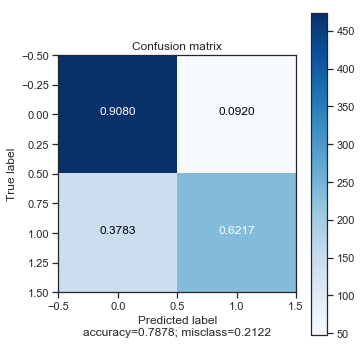

In [9]:
# Select Model

clf = train_keras_model(m.zhang_cnn, 5, 32, X_train, y_train, X_val, y_val)
#clf = LinearSVC().fit(X_train, y_train)
#clf = AdaBoostClassifier(n_estimators=100).fit(X_train, y_train)
#clf = LogisticRegression().fit(X_train, y_train)
#clf = MultinomialNB().fit(X_train, y_train)
#clf = SVC().fit(X_train, y_train)
#clf = KNeighborsClassifier(300).fit(X_train, y_train)
#clf = XGBClassifier().fit(X_train, y_train)

evaluate_model(clf, X_test, y_test)

In [6]:
model = k.models.load_model('model.h5')

NameError: name 'k' is not defined

In [606]:
clfs[lang][task] = clf
clf.save("{}_{}_model.h5".format(lang,task))

In [ ]:
texts[rights].apply(len).hist()

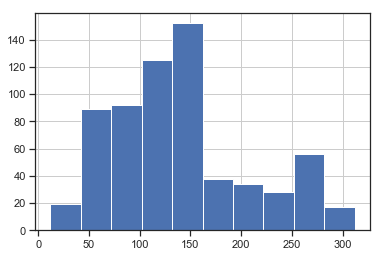

In [73]:
wrong.apply(len).hist()

In [12]:
wlen = np.array([len(x) for x in texts.values])

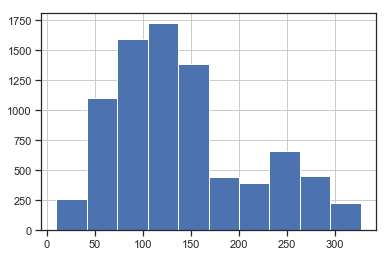

In [15]:
pd.Series(wlen[rights]).hist()

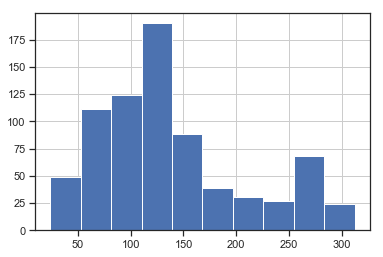

In [16]:
pd.Series(wlen[rights == False]).hist()

In [11]:
rights = pd.Series(np.round(clf.predict(r)).flatten() == 0 ^ pd.Series(y == 1).values)
#wrong_sents = tokenizer.sequences_to_texts(X_test[wrongs])
wrong = texts[rights == False]
wrong

1       Why would young fighting age men be the vast m...
25      @WattersWorld @JesseBWatters @BillSpadea How a...
33      The real truth is after Cologne and in the Nor...
46      This is what the streets of the #uk will look ...
74      Good news.We are against illegal immigrants.Ba...
98      This immigrant should be hung or shot! Period!...
106     @Kashou_ @soulofkab real talk do you have eyes...
133     @Daily_Record I bit my toungue when l heard Sy...
144     South Koreans Stand Against Islamic Immigratio...
150     Daily migrant invasions  #migrant #buildthewal...
170     sharia Law Tessa is that not tony Blair's wife...
178     @DrARWN We need a moratorium on all immigratio...
183     @TheEconomist Stop the immigration of all 40 m...
185     @TelegraphNews We stand with the woman of Colo...
188     No wonder so many "refugees" are accused of fr...
210     @BetterDwelling @KMGVictoria To ignore the rol...
211     Poland: our country is safe because we haven't...
213     The sa

In [ ]:
#SUBMISSION

In [595]:
testset = pd.read_csv("data/test_{}.tsv".format(lang), encoding="UTF-8", delimiter="\t")

In [596]:
X = pipe(testset.text, glove_pipe[:-1])
X.shape

Pipe: preprocess
Pipe: splitting
Pipe: vectorizing
Pipe: padding


(3000, 150, 100)

In [597]:
testset["HS"] = np.round(clf.predict(X)).flatten()

In [598]:
testset["AG"] = 0
testset["TR"] = 0

In [582]:
testset["HS"] = testset.HS.astype(int)
testset["TR"] = testset.TR.astype(int)
testset["AG"] = testset.AG.astype(int)

In [607]:
testset.loc[testset.HS == 1, "AG"] = np.round(clf.predict(X[testset.HS == 1])).flatten()

In [608]:
testset[["id","HS"]].to_csv("{}_a.tsv".format(lang), sep="\t", header=False, index=False)
testset[["id","HS","TR","AG"]].to_csv("{}_b.tsv".format(lang), sep="\t", header=False, index=False)